# DTSC 100  Group 18 Project 




### INTRODUCTION

Forest fires are a disaster that harms both the environment and the economy through the damage that they cause to our planet. Algeria is known to be one of the many countries that have been greatly affected by forest fires. The data set Algerian Forest Fires from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++) contains attributes that were collected to determine the probability of forest fires occurring from many different factors. We are trying to answer whether or not fires can be accurately predicted by using a k-nearest neighbors classification on factors such as rain, wind speed, temperature, and humidity.

The data set contains information about forest fires in two regions of Algeria, the Bejaia region that is located in the Northeast of Algeria, and the Sidi Bel-abbes region located in the Northwest of Algeria, both of these regions are combined together into one data set. We will be using the Bejaia region within this project. The data set includes 11 attributes and 1 output attribute (class). Some of the characteristics in the data are date, temperature, relative humidity, rain, and FWI components. 
Citation:
Faroudja ABID et al. , â€œPredicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithmâ€, International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019) , 08 - 11 July , 2019, Marrakech, Morocco.


### METHOD AND RESULTS

In [6]:
library(tidyverse)
library(repr)
library(tidymodels)

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

download.file(url, destfile = "algerian_fires.csv")
fire_df <- read_csv("algerian_fires.csv", skip = 1)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                 file
123  -- 14 columns 1 columns  'algerian_fires.csv'
168  -- 14 columns 13 columns 'algerian_fires.csv'
”


In [3]:
#make class as factor. turn month day year into date. 
#select all columns except fwi, month, day year
#re order columns so date first
# take only rows from first region
df <- fire_df %>% 
        mutate(Classes = as.factor(Classes), date = as.Date(paste(month, day, year, sep = "."), format = "%m.%d.%y")) %>% 
        select(-FWI, -month, -year, -day) %>% 
        select(date, everything()) %>% 
        slice(1:122)

#make all rows except classes as numeric
df[, 2:10] <- sapply(df[, 2:10] , as.numeric)

#splitting into training and testing data
set.seed(1)
fire_split <- initial_split(df, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

In [4]:
summary(fire_train)

      date             Temperature          RH             Ws       
 Min.   :2020-06-01   Min.   :22.00   Min.   :47.0   Min.   :11.00  
 1st Qu.:2020-06-30   1st Qu.:29.00   1st Qu.:59.0   1st Qu.:14.00  
 Median :2020-07-29   Median :31.00   Median :67.0   Median :15.00  
 Mean   :2020-07-30   Mean   :31.15   Mean   :67.8   Mean   :15.85  
 3rd Qu.:2020-08-30   3rd Qu.:34.00   3rd Qu.:77.0   3rd Qu.:18.00  
 Max.   :2020-09-30   Max.   :37.00   Max.   :89.0   Max.   :26.00  
      Rain              FFMC            DMC              DC        
 Min.   : 0.0000   Min.   :28.60   Min.   : 1.10   Min.   :  6.90  
 1st Qu.: 0.0000   1st Qu.:64.80   1st Qu.: 3.60   1st Qu.:  9.30  
 Median : 0.0000   Median :81.00   Median : 9.40   Median : 34.10  
 Mean   : 0.8484   Mean   :74.62   Mean   :12.52   Mean   : 53.69  
 3rd Qu.: 0.6000   3rd Qu.:86.80   3rd Qu.:16.40   3rd Qu.: 79.90  
 Max.   :16.8000   Max.   :90.30   Max.   :54.20   Max.   :220.40  
      ISI              BUI            Cla

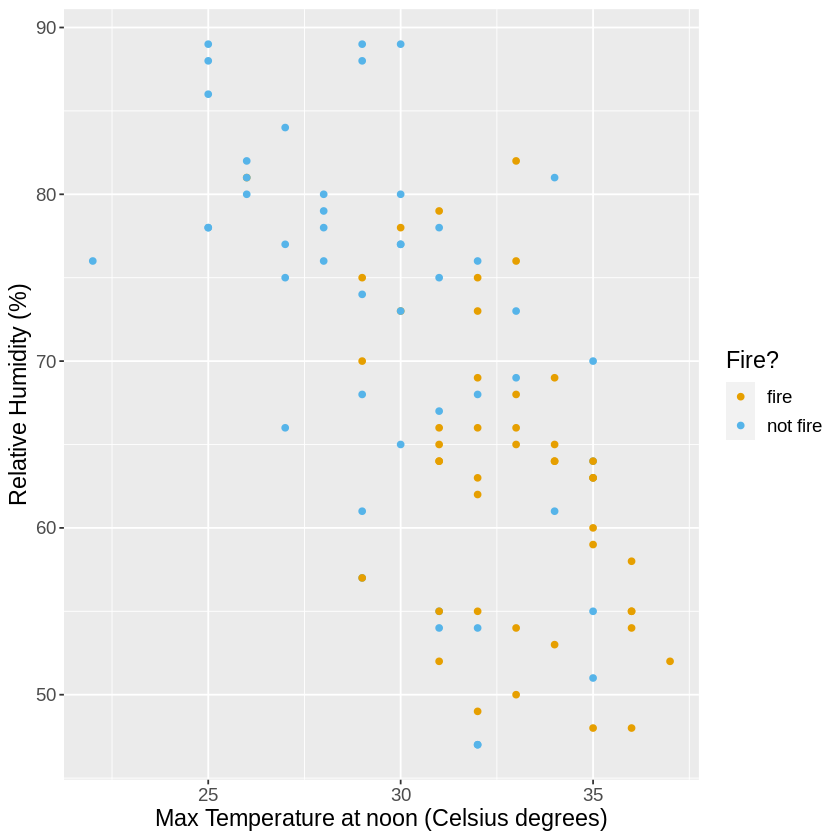

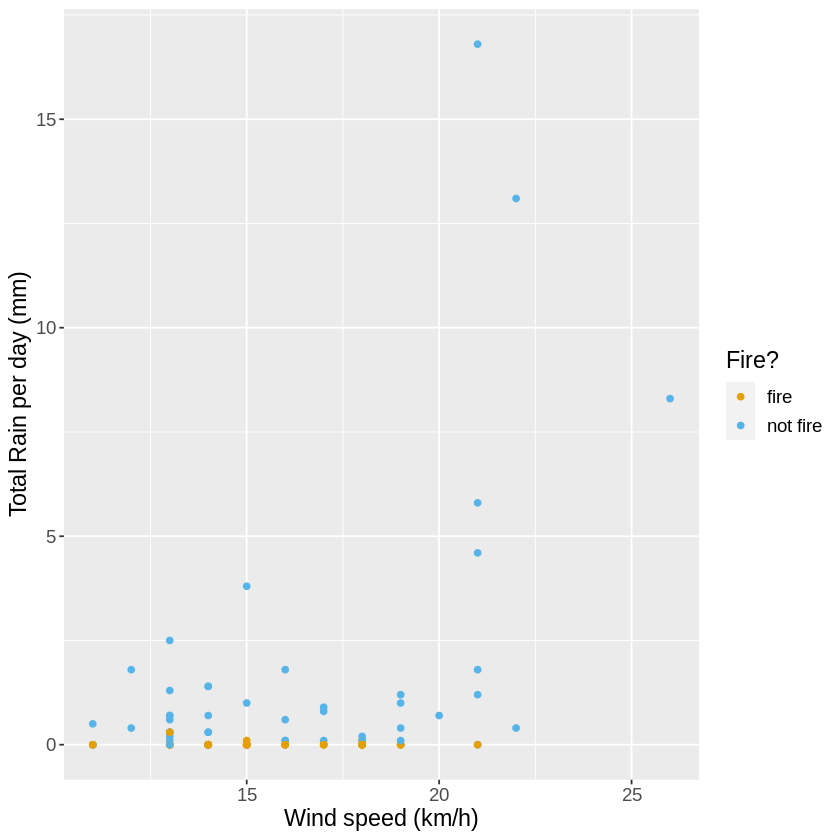

In [5]:
## Visualization plot examples 
cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")
Temp_RH_plot <- ggplot(fire_train, aes(x = Temperature, y = RH, colour = Classes)) + 
                geom_point() + 
                labs(x = "Max Temperature at noon (Celsius degrees)", y = "Relative Humidity (%)", color = "Fire?") + 
                scale_color_manual(values = cbPalette) +
                theme(text = element_text(size = 14))


Temp_RH_plot

WS_Rain_plot <- ggplot(fire_train, aes(x = Ws, y = Rain, colour = Classes)) + 
                geom_point() + 
                labs(x = "Wind speed (km/h)", y = "Total Rain per day (mm)", color = "Fire?") + 
                scale_color_manual(values = cbPalette) + 
                theme(text = element_text(size = 14))


WS_Rain_plot

! Fold1: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold2: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold3: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold4: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold5: internal: No observations were detected in `truth` for level(s): 'Classe...



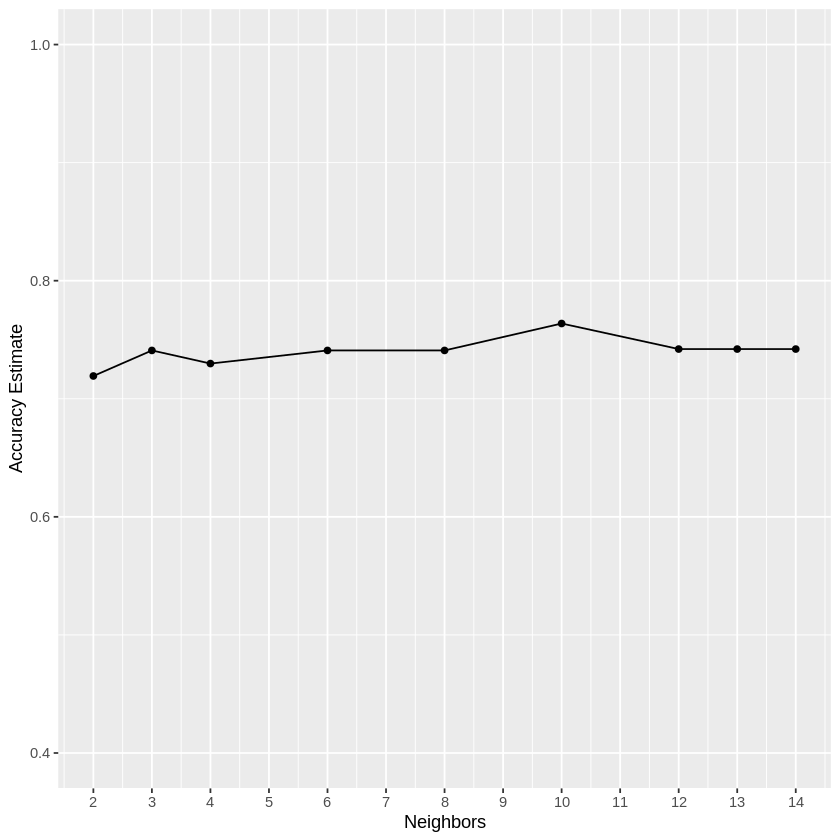

In [10]:
### Evaluation of Temperature and Relative Humidity 

fire_training_vfold <- vfold_cv(fire_train, v = 5, strata = Classes)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
      set_mode("classification") 

cross_val_recipe <- recipe(Classes ~ Rain + RH ,  data = fire_train) 

cross_val_metrics <- workflow() %>%
                add_recipe(cross_val_recipe) %>%
                add_model(knn_tune) %>%
                tune_grid(resamples = fire_training_vfold, grid = 10) %>%
                collect_metrics()


accuracies <- cross_val_metrics %>% 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis



cross_val_plot